# Grad-CAM
Развитием Развитием **Gradient Ascent** для сверточных нейронных сетей **CNN**, является метод **Grad-CAM** (Class activation maps).

## Идея метода

После каждого **сверточного слоя** нейронной сети мы получаем **карты признаков**, сохраняющие информацию о **расположении объектов** на исходном изображении. При этом все значения признаков для одного канала получаются одним и тем же преобразование исходного изображения (получаются применением одинаковых сверток с одинаковыми весами), то есть **один канал** - это **карта одного признака**. 

 Посмотрим на карты признаков для **ResNet-18**. Для этого загрузим модель вместе с весами.

In [ ]:
import torchvision.models as models

resnet = models.resnet18(weights='ResNet18_Weights.DEFAULT')
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Нам интересны сложные признаки, которые выделяются на последних сверточных слоях. ResNet-18 был обучен на ImageNet с размерами входного изображения 224x224. Посмотрим на размеры на выходе последнего сверточного слоя. 

In [ ]:
from torchsummary import summary

summary(resnet, (3, 224, 224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

На последнем сверточном слое получаем 512 каналов 7x7, для их сохранения напишем hook в котором будем сохранять значения активации на выходе модели. На этот раз оформим hook через класс. 


In [ ]:
class ForwardHook():

    def __init__(self, layer):
        self.hook = layer.register_forward_hook(self.hook_func)

    def hook_func(self, layer, input_, output): 
        self.activation = output.detach().clone()

    def __enter__(self, *args): 
        return self

    def __exit__(self, *args): 
      self.hook.remove()

Скачаем картинку, для которой будем смотреть на карты.

In [ ]:
!wget -q 'https://edunet.kea.su/repo/EduNet-web_dependencies/L10/cat_and_dog1.jpg' -O cat_and_dog1.jpg

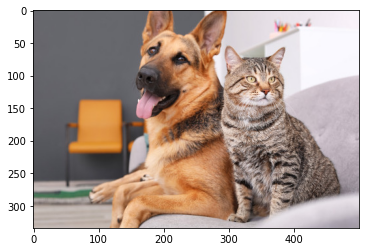

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

img = get_image('cat_and_dog1.jpg')
plt.imshow(img)
plt.show()

Предобработаем картинку: приведем к размеру 224x224 и нормализуем изображение в соответствии со статистикой ImageNet.

In [ ]:
import torch
from torchvision import transforms

# save without normalize for plot
image  = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor()
])(img)
image = image.numpy().transpose(1, 2, 0)

img = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])(img)

print(img.shape)

img = torch.unsqueeze(img, dim=0)
print(img.shape)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


Пропустим картинку через сеть и сохраним значения активаций. 

In [ ]:
with ForwardHook(resnet._modules['layer4']) as forward_hook:
    output = resnet.eval()(img)
    activation = forward_hook.activation

print(activation.shape)

torch.Size([1, 512, 7, 7])


Нарисуем первые 8 карт признаков, чтобы растянуть карты по размеру изображения используем `extent` и `interpolation='bilinear'`

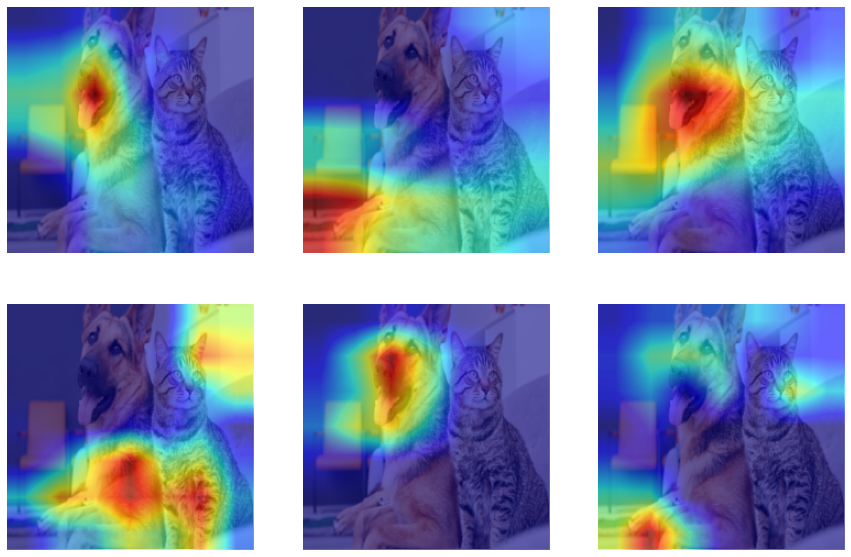

In [ ]:
fif, axs = plt.subplots(2, 3, figsize=(15, 10))

axs = axs.ravel()
for i in range(6):
    axs[i].imshow(image)
    axs[i].imshow(activation[0][i], alpha=0.6, extent=(0, 224, 224, 0),
                  interpolation='bilinear', cmap='jet')  
    axs[i].axis('off');

Загрузим данные о классах.

In [ ]:
!wget -q 'https://edunet.kea.su/repo/EduNet-web_dependencies/L10/imagenet_class_index.json' -O imagenet_class_index.json
import json

idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('/content/imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}

Посмотрим на предсказание модели. 

In [ ]:
import torch.nn.functional as F

number_of_top_classes = 6

prediction = F.softmax(output, dim=1)
top_props, top_inds = prediction.topk(number_of_top_classes)


for i in range(number_of_top_classes):
    category_name = idx2label[top_inds[0][i].item()]
    score = top_props[0][i].item()
    print(f"{category_name} {top_inds[0][i].item()}: {100 * score:.1f}%")

German_shepherd 235: 14.2%
tabby 281: 10.5%
tiger_cat 282: 8.9%
Egyptian_cat 285: 4.5%
space_heater 811: 2.0%
bull_mastiff 243: 2.0%


Мы смогли понять к какой части изображения относятся те или иные признаки. Теперь попробуем понять, как они соотносятся с классом. Мы помним, что градиент указывает направление возрастания функции. Если мы выберем логит, соответствующий метке класса и посчитаем для него градиент, то мы сможем увидеть какие признаки имеют положительные значения (при их увеличении модель будет больше уверена в оценке). 

Напишим хук для сохранения значения градиента. Напишим хук для сохранения значения градиента. Мы смотрим значения градиента на выходе слоя перед `AdaptiveAvgPool2d`, поэтому сохраним только среднее значения (значения градиента для карт признаков одного канала будет одинаковым).

In [ ]:
class HookBackward():
    def __init__(self, layer):
        self.hook = layer.register_backward_hook(self.hook_func) 

    def hook_func(self, layer, grad_input_, grad_output): 
        self.grad = grad_output[0].detach().clone().mean(dim=[2,3], keepdim=True)

    def __enter__(self, *args): 
        return self

    def __exit__(self, *args): 
        self.hook.remove()

Итоговая формула **Grad-CAM** (Class activation maps): 

$$CAM = ReLU(\sum_{i=1}^{Nch}w_iA_i)$$

где $A_i$ - каналы карты признаков, $w_i$ - веса, полученные пропусканием градиента по логиту, соответствующему метке класса. $ReLU$ используется, потому, что нам интересны только положительно влияющие на метку класса признаки. 

Функция расчитывающая CAM.

In [ ]:
def get_cam_map(model, layer, img, class_num):
    with HookBackward(layer) as backward_hook:
        with ForwardHook(layer) as forward_hook:
            output = model.eval()(img)
            activation = forward_hook.activation
        output[0, class_num].backward()
        weight = backward_hook.grad
        cam_map = F.relu((weight[0] * activation[0]).sum(0)).detach().cpu()
    return cam_map

Визуализация важности признаков для top6 классов.

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1113: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


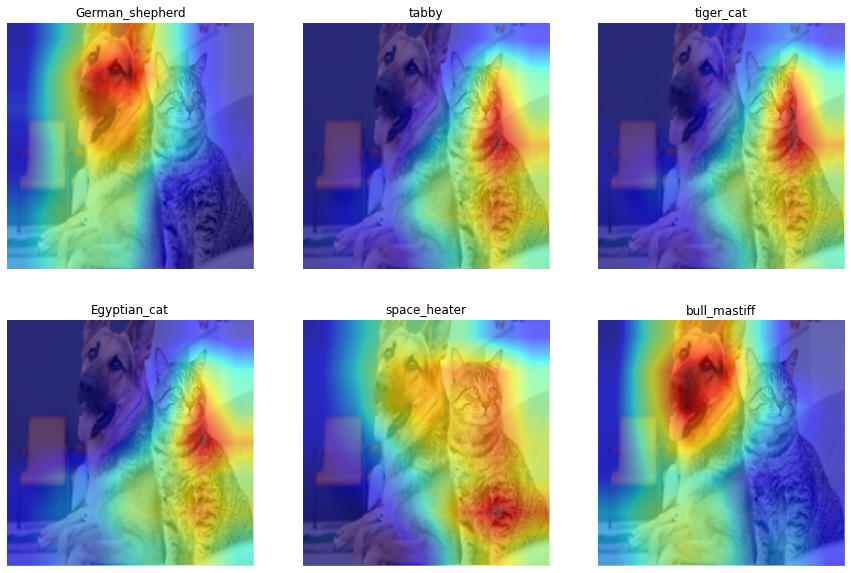

In [ ]:
fif, axs = plt.subplots(2, 3, figsize=(15, 10))

axs = axs.ravel()
for i in range(6):

    cam_map = get_cam_map(resnet, resnet._modules['layer4'], img, top_inds[0][i])

    axs[i].imshow(image)
    axs[i].imshow(cam_map, alpha=0.6, extent=(0, 224, 224, 0),
                  interpolation='bilinear', cmap='jet')  
    axs[i].set_title(idx2label[top_inds[0][i].item()])
    axs[i].axis('off');

## Библиотека Grad-CAM

Можно сделать все то же самое с помощью библиотеки  Grad-CAM.

In [ ]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached grad-cam-1.4.6.tar.gz (7.8 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached ttach-0.0.3-py3-none-any.whl (9.8 kB)
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=acbb835b11190b7d43484fd17126e11b6cd89543c77b5c4a3f5b4de0e06ff5ea
  Stored in directory: /root/.cache/pip/wheels/53/02/43/1f75726b5c28459596067ad91e36951463c01273eef661f09f
Successfully built grad-cam


In [ ]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import preprocess_image

target = [ClassifierOutputTarget(top_inds[0][0])]

target_layers = [resnet._modules['layer4']]

cam = GradCAM(model=resnet, target_layers=target_layers)

grayscale_cams = cam(input_tensor=img, targets=target)

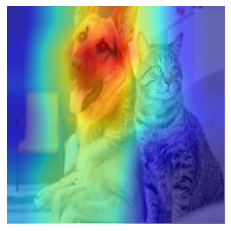

In [ ]:
_,ax = plt.subplots()
ax.imshow(image)
ax.imshow(grayscale_cams[0], alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='jet')
ax.axis('off');

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

target_layers = [resnet._modules['layer4']]

cam = GradCAM(model=resnet, target_layers=target_layers)

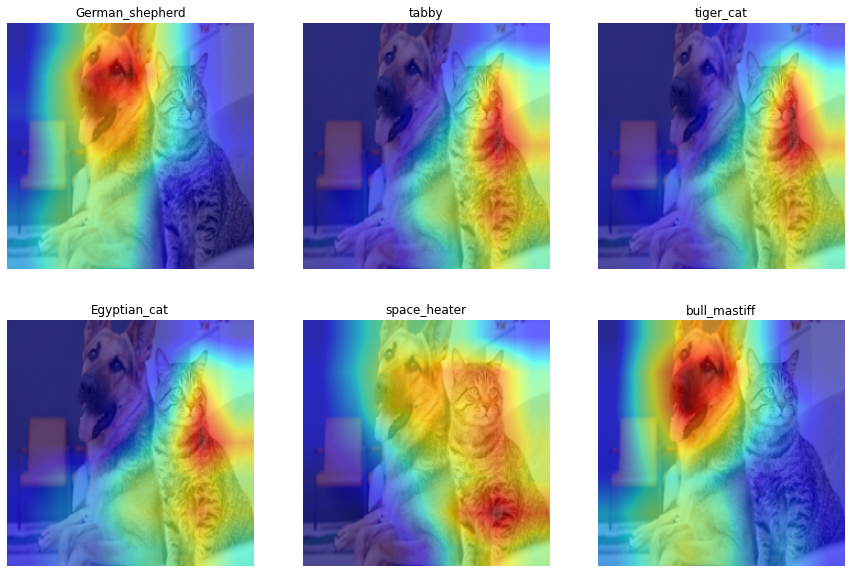

In [ ]:
fif, axs = plt.subplots(2, 3, figsize=(15, 10))

axs = axs.ravel()
for i in range(6):
    
    target = [ClassifierOutputTarget(top_inds[0][i])]
    cam_map = cam(input_tensor=img, targets=target)

    axs[i].imshow(image)
    axs[i].imshow(cam_map[0], alpha=0.6, interpolation='bilinear', cmap='jet')  
    axs[i].set_title(idx2label[top_inds[0][i].item()])
    axs[i].axis('off');

В библиотеке также реализованы другие методы визуализации, например Grad-CAM++, использующий градиенты второго порядка. 

In [ ]:
from pytorch_grad_cam import GradCAMPlusPlus

target_layers = [resnet._modules['layer4']]
cam_plus = GradCAMPlusPlus(model=resnet, target_layers=target_layers)

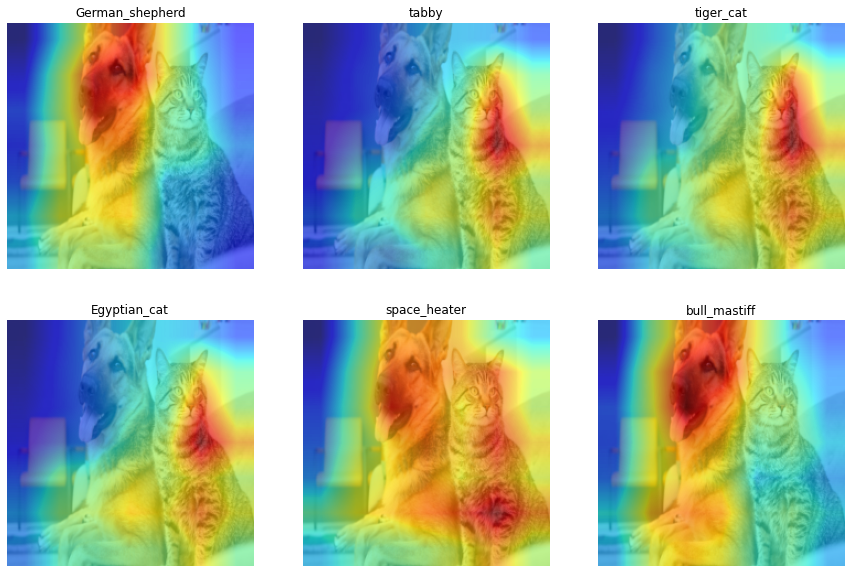

In [ ]:
fif, axs = plt.subplots(2, 3, figsize=(15, 10))

axs = axs.ravel()
for i in range(6):
    
    target = [ClassifierOutputTarget(top_inds[0][i])]
    cam_map = cam_plus(input_tensor=img, targets=target)

    axs[i].imshow(image)
    axs[i].imshow(cam_map[0], alpha=0.6, interpolation='bilinear', cmap='jet')  
    axs[i].set_title(idx2label[top_inds[0][i].item()])
    axs[i].axis('off');

Grad-CAM++ для ряда изображений работает лучше Grad-CAM.

<center><img src="https://edunet.kea.su/repo/EduNet-web_dependencies/L10/Grad_CAM_plus_plus.png" alt="alttext" width=600/></center>

<center><p><em>Source: <a href="https://arxiv.org/pdf/1710.11063.pdf">Grad-CAM++: Improved Visual Explanations for
Deep Convolutional Networks</a></p> </em></center>

Подробнее о других методах читайте в [документации grad-cam](https://jacobgil.github.io/pytorch-gradcam-book/introduction.html).